# Patch Level ResNext Classifier Training

Magnification: 20x, 40x, mixed

Colour spaces: RGB, CIELAB

Transfer Learning: only available for RGB

## Prerequisites and Setup

In [1]:
import glob
import logging
import random
import time
import gc

import numpy as np
import matplotlib.pyplot as plt

import cv2
import torchstain

import torch
from torch.utils.data import DataLoader
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2


from patch_dataset import PatchDataset
from class_mapping import NAME2TYPELABELS_MAP, NAME2SUBTYPELABELS_MAP, LABELS2TYPE_MAP, LABELS2SUBTYPE_MAP
from train_utils import run_train_loop, seed_worker, plot_history
from log_utils import setup_logging

In [2]:
setup_logging()

2023-08-26 04:10:54,726-INFO-Logging setup complete.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
logging.info(f"pytorch device using: {device}")

2023-08-26 04:10:55,024-INFO-pytorch device using: cuda


### Variables and Constants

Paths, parameters, etc.

In [4]:
MAGNIFICATION = "20x"
COLOR_SPACE = "RGB"
CLASS_MAP = NAME2TYPELABELS_MAP
LABEL_MAP = LABELS2TYPE_MAP

PATCH_PATH = "./data/roi_patches"

# relative to script execution path
OUTPUT_PLOT_PATH = "./output/plots"
MODEL_SAVEPATH = "./models"

### Data File Paths

In [5]:
# load dataset
train_patches_paths = sorted(glob.glob(f"{PATCH_PATH}/train/**/*-{MAGNIFICATION}"))

train_img_path = []
train_mask_path = []

for roi in train_patches_paths:
    train_img_path.extend(glob.glob(roi + "/patch/*.png"))
    train_mask_path.extend(glob.glob(roi + "/mask/*.png"))

train_img_path.sort()
train_mask_path.sort()

assert len(train_img_path) == len(train_mask_path), "Number of images and masks should be equal"

logging.info(f"Number of {MAGNIFICATION} train images: {len(train_img_path)}")

val_patches_paths = sorted(glob.glob(f"{PATCH_PATH}/val/**/*-{MAGNIFICATION}"))

val_img_path = []
val_mask_path = []

for roi in val_patches_paths:
    val_img_path.extend(glob.glob(roi + "/patch/*.png"))
    val_mask_path.extend(glob.glob(roi + "/mask/*.png"))

val_img_path.sort()
val_mask_path.sort()

assert len(val_img_path) == len(val_mask_path), "Number of images and masks should be equal"

logging.info(f"Number of {MAGNIFICATION} val images: {len(val_img_path)}")

2023-08-26 04:10:55,374-INFO-Number of 20x train images: 24187
2023-08-26 04:10:55,404-INFO-Number of 20x val images: 2102


### Augmentations

In [6]:
train_transform = A.Compose([
    A.Resize(256, 256),
    A.Rotate([90, 90], p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(256, 256),
    ToTensorV2()
])

In [7]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

### Stain normalisation

Display the image selected for normalisation

In [9]:
train_norm_img_path = train_img_path[len(train_img_path)//2]
train_norm_img_arr = cv2.cvtColor(cv2.imread(train_norm_img_path), cv2.COLOR_BGR2RGB)
plt.imshow(train_norm_img_arr)
plt.title(f"image selected for normalisation in training set: {train_img_path}")
plt.show()

ValueError: Image size of 15217948x433 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>

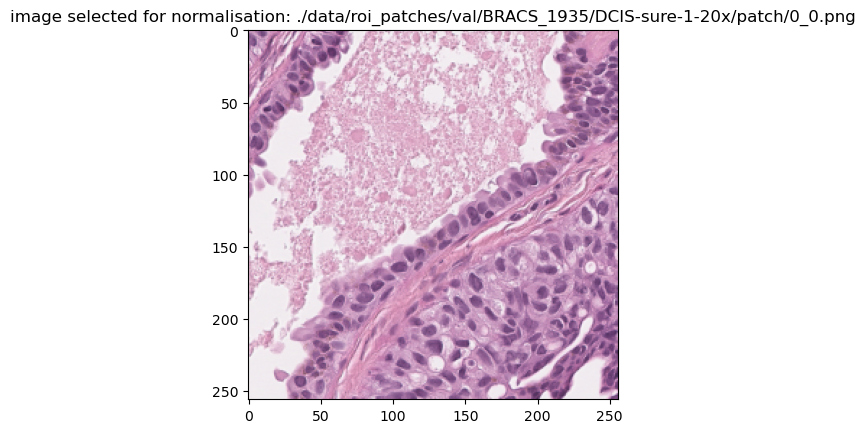

In [ ]:
val_norm_img_path = val_img_path[len(val_img_path)//2]
val_norm_img_arr = cv2.cvtColor(cv2.imread(val_norm_img_path), cv2.COLOR_BGR2RGB)
plt.imshow(val_norm_img_arr)
plt.title(f"image selected for normalisation in validation set: {val_norm_img_path}")
plt.show()

In [ ]:
train_stain_normaliser = torchstain.normalizers.MacenkoNormalizer(backend='numpy')
train_stain_normaliser.fit(train_norm_img_arr)

val_stain_normaliser = torchstain.normalizers.MacenkoNormalizer(backend='numpy')
val_stain_normaliser.fit(val_norm_img_arr)

### Dataset definition

In [ ]:
train_dataset = PatchDataset(
    train_img_path, train_mask_path, mode=COLOR_SPACE, name_to_class_mapping=CLASS_MAP,
    stain_normaliser=train_stain_normaliser,
    level="patch", transform=train_transform, seed=0
)

val_dataset = PatchDataset(
    val_img_path, val_mask_path, mode=COLOR_SPACE, name_to_class_mapping=CLASS_MAP,
    stain_normaliser=val_stain_normaliser,
    level="patch", transform=val_transform, seed=0
)

In [ ]:
num_classes = len(LABEL_MAP) + 1

### Transfer Learning Model definition

In [ ]:
# Transfer learning
model = torchvision.models.resnext50_32x4d(weights=torchvision.models.resnet.ResNeXt50_32X4D_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, num_classes)

In [ ]:
torch.cuda.empty_cache()
gc.collect()

9

## Training

In [ ]:
# define the hyperparameters
LEARNING_RATE = 1e-4
BATCHSIZE = 8
EPOCHS = 100
NUM_WORKERS = 8
PREFETCH_FACTOR = 4
WEIGHT_DECAY = 1e-4

### RGB-20x Transfer Learning

In [ ]:
if __name__ == "__main__":


    # dataloaders
    worker_g = torch.Generator()
    worker_g.manual_seed(0)

    train_batches = DataLoader(
        train_dataset, batch_size=BATCHSIZE, shuffle=True,
        num_workers=NUM_WORKERS, worker_init_fn=seed_worker, pin_memory=True, prefetch_factor=PREFETCH_FACTOR
    )
    worker_g.manual_seed(0)
    valid_batches = DataLoader(
        val_dataset, batch_size=BATCHSIZE, shuffle=False,
        num_workers=NUM_WORKERS, worker_init_fn=seed_worker, pin_memory=True, prefetch_factor=PREFETCH_FACTOR
    )

    # define the loss function and the optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    start_time = time.time()

    set_name = f"resnext_{COLOR_SPACE}_{'mixed' if MAGNIFICATION == '*' else MAGNIFICATION}_trnsfrlng"

    def eval_fn(output:torch.Tensor, targets: torch.Tensor, num_classes):
        # calculate the accuracy
        output = torch.argmax(output, dim=1)
        acc = (output == targets).sum().item() / output.shape[0]
        return acc

    # train the network
    history = run_train_loop(
        model, 8, device,
        train_batches, valid_batches,
        EPOCHS, criterion, optimizer,
        set_name, eval_fn, model_type="classification",
        save_interval=50, save_path=MODEL_SAVEPATH
    )

    # display the total time needed to perform the training
    end_time = time.time()
    logging.info(f"main - Total time taken to train the {set_name} model: {(end_time - start_time):.2f}s")

    # plot the loss and accuracy history
    plot_history(history, save_path=f"{OUTPUT_PLOT_PATH}/{set_name}_history.png", model_type="classification")

 20%|██        | 609/3024 [01:02<03:51, 10.42it/s]

In [ ]:
model = torchvision.models.resnext50_32x4d(num_classes=num_classes)
model.load_state_dict(torch.load(f"./models/resnext_{COLOR_SPACE}_{'mixed' if MAGNIFICATION == '*' else MAGNIFICATION}_trnsfrlng_best_model.pth")["model_state_dict"])

<All keys matched successfully>

### RGB-40x Transfer Learning

In [ ]:
torch.cuda.empty_cache()
gc.collect()

In [ ]:
MAGNIFICATION = "40x"
COLOR_SPACE = "RGB"

train_dataset = PatchDataset(
    train_img_path, train_mask_path, mode=COLOR_SPACE, name_to_class_mapping=CLASS_MAP,
    stain_normaliser=train_stain_normaliser,
    level="patch", transform=train_transform, seed=0
)

val_dataset = PatchDataset(
    val_img_path, val_mask_path, mode=COLOR_SPACE, name_to_class_mapping=CLASS_MAP,
    stain_normaliser=val_stain_normaliser,
    level="patch", transform=val_transform, seed=0
)

model = torchvision.models.resnext50_32x4d(weights=torchvision.models.resnet.ResNeXt50_32X4D_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, num_classes)

if __name__ == "__main__":


    # dataloaders
    worker_g = torch.Generator()
    worker_g.manual_seed(0)

    train_batches = DataLoader(
        train_dataset, batch_size=BATCHSIZE, shuffle=True,
        num_workers=NUM_WORKERS, worker_init_fn=seed_worker, pin_memory=True, prefetch_factor=PREFETCH_FACTOR
    )
    worker_g.manual_seed(0)
    valid_batches = DataLoader(
        val_dataset, batch_size=BATCHSIZE, shuffle=False,
        num_workers=NUM_WORKERS, worker_init_fn=seed_worker, pin_memory=True, prefetch_factor=PREFETCH_FACTOR
    )

    # define the loss function and the optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    start_time = time.time()

    set_name = f"resnext_{COLOR_SPACE}_{'mixed' if MAGNIFICATION == '*' else MAGNIFICATION}_trnsfrlng"

    def eval_fn(output:torch.Tensor, targets: torch.Tensor, num_classes):
        # calculate the accuracy
        output = torch.argmax(output, dim=1)
        acc = (output == targets).sum().item() / output.shape[0]
        return acc

    # train the network
    history = run_train_loop(
        model, 8, device,
        train_batches, valid_batches,
        EPOCHS, criterion, optimizer,
        set_name, eval_fn, model_type="classification",
        save_interval=50, save_path=MODEL_SAVEPATH
    )

    # display the total time needed to perform the training
    end_time = time.time()
    logging.info(f"main - Total time taken to train the {set_name} model: {(end_time - start_time):.2f}s")

    # plot the loss and accuracy history
    plot_history(history, save_path=f"{OUTPUT_PLOT_PATH}/{set_name}_history.png", model_type="classification")

### RGB-mixed Transfer Learning

In [ ]:
torch.cuda.empty_cache()
gc.collect()

In [ ]:
MAGNIFICATION = "*"
COLOR_SPACE = "RGB"

train_dataset = PatchDataset(
    train_img_path, train_mask_path, mode=COLOR_SPACE, name_to_class_mapping=CLASS_MAP,
    stain_normaliser=train_stain_normaliser,
    level="patch", transform=train_transform, seed=0
)

val_dataset = PatchDataset(
    val_img_path, val_mask_path, mode=COLOR_SPACE, name_to_class_mapping=CLASS_MAP,
    stain_normaliser=val_stain_normaliser,
    level="patch", transform=val_transform, seed=0
)

model = torchvision.models.resnext50_32x4d(weights=torchvision.models.resnet.ResNeXt50_32X4D_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, num_classes)

if __name__ == "__main__":


    # dataloaders
    worker_g = torch.Generator()
    worker_g.manual_seed(0)

    train_batches = DataLoader(
        train_dataset, batch_size=BATCHSIZE, shuffle=True,
        num_workers=NUM_WORKERS, worker_init_fn=seed_worker, pin_memory=True, prefetch_factor=PREFETCH_FACTOR
    )
    worker_g.manual_seed(0)
    valid_batches = DataLoader(
        val_dataset, batch_size=BATCHSIZE, shuffle=False,
        num_workers=NUM_WORKERS, worker_init_fn=seed_worker, pin_memory=True, prefetch_factor=PREFETCH_FACTOR
    )

    # define the loss function and the optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    start_time = time.time()

    set_name = f"resnext_{COLOR_SPACE}_{'mixed' if MAGNIFICATION == '*' else MAGNIFICATION}_trnsfrlng"

    def eval_fn(output:torch.Tensor, targets: torch.Tensor, num_classes):
        # calculate the accuracy
        output = torch.argmax(output, dim=1)
        acc = (output == targets).sum().item() / output.shape[0]
        return acc

    # train the network
    history = run_train_loop(
        model, 8, device,
        train_batches, valid_batches,
        EPOCHS, criterion, optimizer,
        set_name, eval_fn, model_type="classification",
        save_interval=50, save_path=MODEL_SAVEPATH
    )

    # display the total time needed to perform the training
    end_time = time.time()
    logging.info(f"main - Total time taken to train the {set_name} model: {(end_time - start_time):.2f}s")

    # plot the loss and accuracy history
    plot_history(history, save_path=f"{OUTPUT_PLOT_PATH}/{set_name}_history.png", model_type="classification")

###RGB-20x Scratch

In [ ]:
torch.cuda.empty_cache()
gc.collect()

In [ ]:
MAGNIFICATION = "20x"
COLOR_SPACE = "RGB"

train_dataset = PatchDataset(
    train_img_path, train_mask_path, mode=COLOR_SPACE, name_to_class_mapping=CLASS_MAP,
    stain_normaliser=train_stain_normaliser,
    level="patch", transform=train_transform, seed=0
)

val_dataset = PatchDataset(
    val_img_path, val_mask_path, mode=COLOR_SPACE, name_to_class_mapping=CLASS_MAP,
    stain_normaliser=val_stain_normaliser,
    level="patch", transform=val_transform, seed=0
)

model = torchvision.models.resnext50_32x4d(num_classes=num_classes)

if __name__ == "__main__":


    # dataloaders
    worker_g = torch.Generator()
    worker_g.manual_seed(0)

    train_batches = DataLoader(
        train_dataset, batch_size=BATCHSIZE, shuffle=True,
        num_workers=NUM_WORKERS, worker_init_fn=seed_worker, pin_memory=True, prefetch_factor=PREFETCH_FACTOR
    )
    worker_g.manual_seed(0)
    valid_batches = DataLoader(
        val_dataset, batch_size=BATCHSIZE, shuffle=False,
        num_workers=NUM_WORKERS, worker_init_fn=seed_worker, pin_memory=True, prefetch_factor=PREFETCH_FACTOR
    )

    # define the loss function and the optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    start_time = time.time()

    set_name = f"resnext_{COLOR_SPACE}_{'mixed' if MAGNIFICATION == '*' else MAGNIFICATION}"

    def eval_fn(output:torch.Tensor, targets: torch.Tensor, num_classes):
        # calculate the accuracy
        output = torch.argmax(output, dim=1)
        acc = (output == targets).sum().item() / output.shape[0]
        return acc

    # train the network
    history = run_train_loop(
        model, 8, device,
        train_batches, valid_batches,
        EPOCHS, criterion, optimizer,
        set_name, eval_fn, model_type="classification",
        save_interval=50, save_path=MODEL_SAVEPATH
    )

    # display the total time needed to perform the training
    end_time = time.time()
    logging.info(f"main - Total time taken to train the {set_name} model: {(end_time - start_time):.2f}s")

    # plot the loss and accuracy history
    plot_history(history, save_path=f"{OUTPUT_PLOT_PATH}/{set_name}_history.png", model_type="classification")

### RGB-40x Scratch

In [ ]:
torch.cuda.empty_cache()
gc.collect()

In [ ]:
MAGNIFICATION = "40x"
COLOR_SPACE = "RGB"

train_dataset = PatchDataset(
    train_img_path, train_mask_path, mode=COLOR_SPACE, name_to_class_mapping=CLASS_MAP,
    stain_normaliser=train_stain_normaliser,
    level="patch", transform=train_transform, seed=0
)

val_dataset = PatchDataset(
    val_img_path, val_mask_path, mode=COLOR_SPACE, name_to_class_mapping=CLASS_MAP,
    stain_normaliser=val_stain_normaliser,
    level="patch", transform=val_transform, seed=0
)

model = torchvision.models.resnext50_32x4d(num_classes=num_classes)

if __name__ == "__main__":


    # dataloaders
    worker_g = torch.Generator()
    worker_g.manual_seed(0)

    train_batches = DataLoader(
        train_dataset, batch_size=BATCHSIZE, shuffle=True,
        num_workers=NUM_WORKERS, worker_init_fn=seed_worker, pin_memory=True, prefetch_factor=PREFETCH_FACTOR
    )
    worker_g.manual_seed(0)
    valid_batches = DataLoader(
        val_dataset, batch_size=BATCHSIZE, shuffle=False,
        num_workers=NUM_WORKERS, worker_init_fn=seed_worker, pin_memory=True, prefetch_factor=PREFETCH_FACTOR
    )

    # define the loss function and the optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    start_time = time.time()

    set_name = f"resnext_{COLOR_SPACE}_{'mixed' if MAGNIFICATION == '*' else MAGNIFICATION}"

    def eval_fn(output:torch.Tensor, targets: torch.Tensor, num_classes):
        # calculate the accuracy
        output = torch.argmax(output, dim=1)
        acc = (output == targets).sum().item() / output.shape[0]
        return acc

    # train the network
    history = run_train_loop(
        model, 8, device,
        train_batches, valid_batches,
        EPOCHS, criterion, optimizer,
        set_name, eval_fn, model_type="classification",
        save_interval=50, save_path=MODEL_SAVEPATH
    )

    # display the total time needed to perform the training
    end_time = time.time()
    logging.info(f"main - Total time taken to train the {set_name} model: {(end_time - start_time):.2f}s")

    # plot the loss and accuracy history
    plot_history(history, save_path=f"{OUTPUT_PLOT_PATH}/{set_name}_history.png", model_type="classification")

### RGB-mixed Scratch

In [ ]:
torch.cuda.empty_cache()
gc.collect()

In [ ]:
MAGNIFICATION = "*"
COLOR_SPACE = "RGB"

train_dataset = PatchDataset(
    train_img_path, train_mask_path, mode=COLOR_SPACE, name_to_class_mapping=CLASS_MAP,
    stain_normaliser=train_stain_normaliser,
    level="patch", transform=train_transform, seed=0
)

val_dataset = PatchDataset(
    val_img_path, val_mask_path, mode=COLOR_SPACE, name_to_class_mapping=CLASS_MAP,
    stain_normaliser=val_stain_normaliser,
    level="patch", transform=val_transform, seed=0
)

model = torchvision.models.resnext50_32x4d(num_classes=num_classes)

if __name__ == "__main__":


    # dataloaders
    worker_g = torch.Generator()
    worker_g.manual_seed(0)

    train_batches = DataLoader(
        train_dataset, batch_size=BATCHSIZE, shuffle=True,
        num_workers=NUM_WORKERS, worker_init_fn=seed_worker, pin_memory=True, prefetch_factor=PREFETCH_FACTOR
    )
    worker_g.manual_seed(0)
    valid_batches = DataLoader(
        val_dataset, batch_size=BATCHSIZE, shuffle=False,
        num_workers=NUM_WORKERS, worker_init_fn=seed_worker, pin_memory=True, prefetch_factor=PREFETCH_FACTOR
    )

    # define the loss function and the optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    start_time = time.time()

    set_name = f"resnext_{COLOR_SPACE}_{'mixed' if MAGNIFICATION == '*' else MAGNIFICATION}"

    def eval_fn(output:torch.Tensor, targets: torch.Tensor, num_classes):
        # calculate the accuracy
        output = torch.argmax(output, dim=1)
        acc = (output == targets).sum().item() / output.shape[0]
        return acc

    # train the network
    history = run_train_loop(
        model, 8, device,
        train_batches, valid_batches,
        EPOCHS, criterion, optimizer,
        set_name, eval_fn, model_type="classification",
        save_interval=50, save_path=MODEL_SAVEPATH
    )

    # display the total time needed to perform the training
    end_time = time.time()
    logging.info(f"main - Total time taken to train the {set_name} model: {(end_time - start_time):.2f}s")

    # plot the loss and accuracy history
    plot_history(history, save_path=f"{OUTPUT_PLOT_PATH}/{set_name}_history.png", model_type="classification")

### CIELAB-20x Scratch

In [ ]:
torch.cuda.empty_cache()
gc.collect()

In [ ]:
MAGNIFICATION = "20x"
COLOR_SPACE = "CIELAB"

train_dataset = PatchDataset(
    train_img_path, train_mask_path, mode=COLOR_SPACE, name_to_class_mapping=CLASS_MAP,
    stain_normaliser=train_stain_normaliser,
    level="patch", transform=train_transform, seed=0
)

val_dataset = PatchDataset(
    val_img_path, val_mask_path, mode=COLOR_SPACE, name_to_class_mapping=CLASS_MAP,
    stain_normaliser=val_stain_normaliser,
    level="patch", transform=val_transform, seed=0
)

model = torchvision.models.resnext50_32x4d(num_classes=num_classes)

if __name__ == "__main__":


    # dataloaders
    worker_g = torch.Generator()
    worker_g.manual_seed(0)

    train_batches = DataLoader(
        train_dataset, batch_size=BATCHSIZE, shuffle=True,
        num_workers=NUM_WORKERS, worker_init_fn=seed_worker, pin_memory=True, prefetch_factor=PREFETCH_FACTOR
    )
    worker_g.manual_seed(0)
    valid_batches = DataLoader(
        val_dataset, batch_size=BATCHSIZE, shuffle=False,
        num_workers=NUM_WORKERS, worker_init_fn=seed_worker, pin_memory=True, prefetch_factor=PREFETCH_FACTOR
    )

    # define the loss function and the optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    start_time = time.time()

    set_name = f"resnext_{COLOR_SPACE}_{'mixed' if MAGNIFICATION == '*' else MAGNIFICATION}"

    def eval_fn(output:torch.Tensor, targets: torch.Tensor, num_classes):
        # calculate the accuracy
        output = torch.argmax(output, dim=1)
        acc = (output == targets).sum().item() / output.shape[0]
        return acc

    # train the network
    history = run_train_loop(
        model, 8, device,
        train_batches, valid_batches,
        EPOCHS, criterion, optimizer,
        set_name, eval_fn, model_type="classification",
        save_interval=50, save_path=MODEL_SAVEPATH
    )

    # display the total time needed to perform the training
    end_time = time.time()
    logging.info(f"main - Total time taken to train the {set_name} model: {(end_time - start_time):.2f}s")

    # plot the loss and accuracy history
    plot_history(history, save_path=f"{OUTPUT_PLOT_PATH}/{set_name}_history.png", model_type="classification")

### CIELAB-40x Scratch

In [ ]:
torch.cuda.empty_cache()
gc.collect()

In [ ]:
MAGNIFICATION = "40x"
COLOR_SPACE = "CIELAB"

train_dataset = PatchDataset(
    train_img_path, train_mask_path, mode=COLOR_SPACE, name_to_class_mapping=CLASS_MAP,
    stain_normaliser=train_stain_normaliser,
    level="patch", transform=train_transform, seed=0
)

val_dataset = PatchDataset(
    val_img_path, val_mask_path, mode=COLOR_SPACE, name_to_class_mapping=CLASS_MAP,
    stain_normaliser=val_stain_normaliser,
    level="patch", transform=val_transform, seed=0
)

model = torchvision.models.resnext50_32x4d(num_classes=num_classes)

if __name__ == "__main__":


    # dataloaders
    worker_g = torch.Generator()
    worker_g.manual_seed(0)

    train_batches = DataLoader(
        train_dataset, batch_size=BATCHSIZE, shuffle=True,
        num_workers=NUM_WORKERS, worker_init_fn=seed_worker, pin_memory=True, prefetch_factor=PREFETCH_FACTOR
    )
    worker_g.manual_seed(0)
    valid_batches = DataLoader(
        val_dataset, batch_size=BATCHSIZE, shuffle=False,
        num_workers=NUM_WORKERS, worker_init_fn=seed_worker, pin_memory=True, prefetch_factor=PREFETCH_FACTOR
    )

    # define the loss function and the optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    start_time = time.time()

    set_name = f"resnext_{COLOR_SPACE}_{'mixed' if MAGNIFICATION == '*' else MAGNIFICATION}"

    def eval_fn(output:torch.Tensor, targets: torch.Tensor, num_classes):
        # calculate the accuracy
        output = torch.argmax(output, dim=1)
        acc = (output == targets).sum().item() / output.shape[0]
        return acc

    # train the network
    history = run_train_loop(
        model, 8, device,
        train_batches, valid_batches,
        EPOCHS, criterion, optimizer,
        set_name, eval_fn, model_type="classification",
        save_interval=50, save_path=MODEL_SAVEPATH
    )

    # display the total time needed to perform the training
    end_time = time.time()
    logging.info(f"main - Total time taken to train the {set_name} model: {(end_time - start_time):.2f}s")

    # plot the loss and accuracy history
    plot_history(history, save_path=f"{OUTPUT_PLOT_PATH}/{set_name}_history.png", model_type="classification")

### CIELAB-mixed Scratch

In [ ]:
torch.cuda.empty_cache()
gc.collect()

In [ ]:
MAGNIFICATION = "*"
COLOR_SPACE = "CIELAB"

train_dataset = PatchDataset(
    train_img_path, train_mask_path, mode=COLOR_SPACE, name_to_class_mapping=CLASS_MAP,
    stain_normaliser=train_stain_normaliser,
    level="patch", transform=train_transform, seed=0
)

val_dataset = PatchDataset(
    val_img_path, val_mask_path, mode=COLOR_SPACE, name_to_class_mapping=CLASS_MAP,
    stain_normaliser=val_stain_normaliser,
    level="patch", transform=val_transform, seed=0
)

model = torchvision.models.resnext50_32x4d(num_classes=num_classes)

if __name__ == "__main__":


    # dataloaders
    worker_g = torch.Generator()
    worker_g.manual_seed(0)

    train_batches = DataLoader(
        train_dataset, batch_size=BATCHSIZE, shuffle=True,
        num_workers=NUM_WORKERS, worker_init_fn=seed_worker, pin_memory=True, prefetch_factor=PREFETCH_FACTOR
    )
    worker_g.manual_seed(0)
    valid_batches = DataLoader(
        val_dataset, batch_size=BATCHSIZE, shuffle=False,
        num_workers=NUM_WORKERS, worker_init_fn=seed_worker, pin_memory=True, prefetch_factor=PREFETCH_FACTOR
    )

    # define the loss function and the optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    start_time = time.time()

    set_name = f"resnext_{COLOR_SPACE}_{'mixed' if MAGNIFICATION == '*' else MAGNIFICATION}"

    def eval_fn(output:torch.Tensor, targets: torch.Tensor, num_classes):
        # calculate the accuracy
        output = torch.argmax(output, dim=1)
        acc = (output == targets).sum().item() / output.shape[0]
        return acc

    # train the network
    history = run_train_loop(
        model, 8, device,
        train_batches, valid_batches,
        EPOCHS, criterion, optimizer,
        set_name, eval_fn, model_type="classification",
        save_interval=50, save_path=MODEL_SAVEPATH
    )

    # display the total time needed to perform the training
    end_time = time.time()
    logging.info(f"main - Total time taken to train the {set_name} model: {(end_time - start_time):.2f}s")

    # plot the loss and accuracy history
    plot_history(history, save_path=f"{OUTPUT_PLOT_PATH}/{set_name}_history.png", model_type="classification")